# Module 04 — Best Model: Bike Sharing Neural Network

## tf.keras Sequential with COVID/Holiday/School Features

**Configuration**: C1_all_features (all data, all feature sets)

| Metric | Value |
|--------|-------|
| Mini Holdout RMSE | **108.11** |
| Mini Holdout R² | **0.9118** |
| Features | 62 |
| Architecture | [128, 64, 32] + BatchNorm + Dropout |
| Loss | Huber (robust to demand outliers) |
| Ensemble | 5-seed averaged |
| Improvement | 110.21 RMSE better than baseline (218.32) |

## 1. Environment Setup

In [1]:
import os
import sys

# Auto-detect environment and set Keras backend
IN_COLAB = "google.colab" in sys.modules
if not IN_COLAB:
    os.environ["KERAS_BACKEND"] = "jax"  # JAX for local GPU acceleration
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import keras
from keras import layers, models, callbacks, regularizers

print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")
print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 982, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 739, in start
    s

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Keras version: 3.13.2
Backend: jax
Environment: Local


## 2. Data Loading

In [2]:
BIKES_URL = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv"
HOLDOUT_URL = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv"
MINI_URL = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv"
MINI_ANSWERS_URL = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini_answers.csv"

df = pd.read_csv(BIKES_URL)
df["dteday"] = pd.to_datetime(df["dteday"], format="mixed")
df["total"] = df["casual"] + df["registered"]

mini_raw = pd.read_csv(MINI_URL)
mini_answers = pd.read_csv(MINI_ANSWERS_URL)
mini_actual = (mini_answers["casual"] + mini_answers["registered"]).values
holdout_raw = pd.read_csv(HOLDOUT_URL)

print(f"Training data: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Date range: {df['dteday'].min().date()} to {df['dteday'].max().date()}")
print(f"Mini holdout: {mini_raw.shape[0]} rows")
print(f"Full holdout: {holdout_raw.shape[0]} rows")

Training data: 112,475 rows, 13 columns
Date range: 2011-01-01 to 2023-10-31
Mini holdout: 384 rows
Full holdout: 1465 rows


## 3. Holiday & School Break Detection

These helper functions identify US federal holidays and school break periods from dates.
They enable the model to capture event-driven demand patterns:
- **Holidays**: Independence Day +52%, Christmas -82%, Thanksgiving -65%
- **School breaks**: Summer +35%, winter -55%, thanksgiving -35%

In [3]:
def get_holiday_name(date):
    """Identify US federal holidays from a date."""
    m, d, dow, yr = date.month, date.day, date.weekday(), date.year
    if m == 1 and d == 1: return "new_years_day"
    if m == 6 and d == 19: return "juneteenth"
    if m == 7 and d == 4: return "independence_day"
    if m == 11 and d == 11: return "veterans_day"
    if m == 12 and d == 25: return "christmas"
    if m == 1 and dow == 0 and 15 <= d <= 21: return "mlk_day"
    if m == 2 and dow == 0 and 15 <= d <= 21: return "presidents_day"
    if m == 5 and dow == 0 and 25 <= d <= 31: return "memorial_day"
    if m == 9 and dow == 0 and 1 <= d <= 7: return "labor_day"
    if m == 10 and dow == 0 and 8 <= d <= 14: return "columbus_day"
    if m == 11 and dow == 3:
        from datetime import date as dt_date
        first_day = dt_date(yr, 11, 1)
        first_thu = (3 - first_day.weekday()) % 7 + 1
        if d == first_thu + 21:
            return "thanksgiving"
    return "none"


def get_school_period(date):
    """Identify school break periods from a date."""
    m, d = date.month, date.day
    if (m == 6 and d >= 15) or m in [7, 8] or (m == 9 and d < 2):
        return "summer_break"
    if (m == 12 and d >= 20) or (m == 1 and d <= 3):
        return "winter_break"
    if (m == 3 and d >= 25) or (m == 4 and d <= 5):
        return "spring_break"
    if m == 11 and 22 <= d <= 26:
        return "thanksgiving_break"
    return "school_in_session"


print("Holiday & school break functions defined.")

Holiday & school break functions defined.


## 4. Feature Engineering (62 Features)

Three feature groups combined:

| Group | Features | Individual RMSE Impact |
|-------|----------|------------------------|
| **COVID era** | `months_since_covid`, `is_covid_lockdown`, `is_covid_era`, `year_num` | -55.78 (91% of total improvement) |
| **Holiday** | 7 holiday one-hots + `is_holiday_adjacent` | -6.89 |
| **School break** | `is_summer_break`, `is_winter_break`, `is_thanksgiving_break`, `is_school_break` | -3.19 |

Plus baseline features: cyclical hour encoding, rush hour, weekend, night, temp interactions, one-hot season/weather/hour.

In [4]:
def engineer_features(data, is_training=True):
    """Engineer all 62 features (baseline + COVID + holiday + school)."""
    d = data.copy()
    d["dteday"] = pd.to_datetime(d["dteday"], format="mixed")
    hr_int = d["hr"].astype(int)
    year = d["dteday"].dt.year
    month = d["dteday"].dt.month

    # ── Baseline features ──
    d["hr_sin"] = np.sin(2 * np.pi * hr_int / 24)
    d["hr_cos"] = np.cos(2 * np.pi * hr_int / 24)
    d["is_rush_hour"] = hr_int.isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
    d["is_weekend"] = (d["dteday"].dt.dayofweek >= 5).astype(int)
    d["is_night"] = hr_int.isin([0, 1, 2, 3, 4, 5, 23]).astype(int)
    d["temp_squared"] = d["temp_c"] ** 2
    d["windspeed_zero"] = (d["windspeed"] == 0).astype(int)
    d["temp_hum"] = d["temp_c"] * d["hum"]
    d["temp_wind"] = d["temp_c"] * d["windspeed"]

    # ── COVID era features ──
    d["months_since_covid"] = ((year - 2020) * 12 + (month - 3)).clip(lower=0)
    d["is_covid_lockdown"] = (
        ((year == 2020) & (month >= 3) & (month <= 6))
    ).astype(int)
    d["is_covid_era"] = (
        ((year == 2020) & (month >= 3)) | (year == 2021)
    ).astype(int)
    d["year_num"] = year - 2011

    # ── Holiday features ──
    d["holiday_name"] = d["dteday"].apply(lambda x: get_holiday_name(x.date()))
    for hol in ["thanksgiving", "christmas", "new_years_day", "veterans_day",
                 "independence_day", "memorial_day", "labor_day"]:
        d[f"hol_{hol}"] = (d["holiday_name"] == hol).astype(int)
    d["date_only"] = d["dteday"].dt.date
    holiday_dates = set(d[d["holiday_name"] != "none"]["date_only"].unique())
    d["is_holiday_adjacent"] = d["date_only"].apply(
        lambda dt: 1 if (pd.Timestamp(dt) - pd.Timedelta(days=1)).date() in holiday_dates
        or (pd.Timestamp(dt) + pd.Timedelta(days=1)).date() in holiday_dates
        else 0
    )
    d = d.drop(columns=["holiday_name", "date_only"])

    # ── School break features ──
    d["school_period"] = d["dteday"].apply(lambda x: get_school_period(x.date()))
    d["is_summer_break"] = (d["school_period"] == "summer_break").astype(int)
    d["is_winter_break"] = (d["school_period"] == "winter_break").astype(int)
    d["is_thanksgiving_break"] = (d["school_period"] == "thanksgiving_break").astype(int)
    d["is_school_break"] = (d["school_period"] != "school_in_session").astype(int)
    d = d.drop(columns=["school_period"])

    # ── One-hot encode categoricals ──
    d = pd.get_dummies(d, columns=["season", "weathersit"],
                       prefix=["season", "weather"], drop_first=False)
    d["hr_int"] = hr_int
    d = pd.get_dummies(d, columns=["hr_int"], prefix="hr", drop_first=False)

    # ── Drop unused columns ──
    drop_cols = ["dteday", "hr", "feels_like_c"]
    if is_training:
        drop_cols += ["casual", "registered"]
    d = d.drop(columns=[c for c in drop_cols if c in d.columns], errors="ignore")
    return d


print("Feature engineering function defined.")

Feature engineering function defined.


## 5. Prepare Training Data

In [5]:
# Engineer features on full training data
df_eng = engineer_features(df, is_training=True)
y = df_eng["total"].values.astype(np.float32)
X = df_eng.drop(columns=["total"])
feature_names = list(X.columns)
print(f"Features: {len(feature_names)}")

# Scale continuous features only
continuous = [c for c in ["temp_c", "hum", "windspeed", "temp_squared",
                          "hr_sin", "hr_cos", "temp_hum", "temp_wind",
                          "months_since_covid", "year_num"] if c in X.columns]
scaler = MinMaxScaler()
X[continuous] = scaler.fit_transform(X[continuous])
X_np = X.values.astype(np.float32)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y, test_size=0.2, random_state=42
)
print(f"Training: {X_train.shape[0]:,} samples")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"\nContinuous features scaled: {continuous}")

Features: 62


Training: 89,980 samples
Validation: 22,495 samples

Continuous features scaled: ['temp_c', 'hum', 'windspeed', 'temp_squared', 'hr_sin', 'hr_cos', 'temp_hum', 'temp_wind', 'months_since_covid', 'year_num']


In [6]:
# Prepare holdout datasets
def prepare_holdout(raw_data):
    """Engineer features and align columns for holdout data."""
    eng = engineer_features(raw_data, is_training=False)
    for col in feature_names:
        if col not in eng.columns:
            eng[col] = 0
    eng = eng[feature_names]
    eng[continuous] = scaler.transform(eng[continuous])
    return eng.values.astype(np.float32)

mini_np = prepare_holdout(mini_raw)
holdout_np = prepare_holdout(holdout_raw)

print(f"Mini holdout prepared: {mini_np.shape}")
print(f"Full holdout prepared: {holdout_np.shape}")

Mini holdout prepared: (384, 62)
Full holdout prepared: (1465, 62)


## 6. Model Training — 5-Seed Ensemble

Architecture: **Sequential [128, 64, 32]** with:
- L2 regularization (1e-4) on all Dense layers
- BatchNormalization after each hidden layer
- Dropout (0.3, 0.2) for regularization
- **Huber loss** — robust to demand outlier spikes
- EarlyStopping (patience=20) + ReduceLROnPlateau

5 models with different random seeds are averaged for a more stable prediction.

In [7]:
seeds = [42, 123, 456, 789, 2025]
all_val_preds = []
all_mini_preds = []
all_holdout_preds = []
histories = []

for i, seed in enumerate(seeds):
    print(f"\n--- Seed {seed} ({i+1}/{len(seeds)}) ---")
    np.random.seed(seed)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dense(1),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="huber",
        metrics=["mae"]
    )

    if i == 0:
        model.summary()

    cb = [
        callbacks.EarlyStopping(
            monitor="val_loss", patience=20, restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6
        ),
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300, batch_size=128,
        callbacks=cb, verbose=0
    )
    histories.append(history)

    best_epoch = np.argmin(history.history["val_loss"]) + 1
    best_val_loss = min(history.history["val_loss"])
    print(f"  Best epoch: {best_epoch}, Val loss: {best_val_loss:.4f}")

    all_val_preds.append(np.maximum(model.predict(X_val, verbose=0).flatten(), 0))
    all_mini_preds.append(np.maximum(model.predict(mini_np, verbose=0).flatten(), 0))
    all_holdout_preds.append(np.maximum(model.predict(holdout_np, verbose=0).flatten(), 0))

print(f"\nAll {len(seeds)} models trained.")


--- Seed 42 (1/5) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape            ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)             │         8,064 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)             │           512 │
│ (BatchNormalization)            │                         │               │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)             │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)              │         8,256 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)              │           256 │
│ (BatchNormalization)            │                         │               │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)              │             0 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)              │         2,080 │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)              │           128 │
│ (BatchNormalization)            │                         │               │
├─────────────────────────────────┼─────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)               │            33 │
└─────────────────────────────────┴─────────────────────────┴───────────────┘

 Total params: 19,329 (75.50 KB)

 Trainable params: 18,881 (73.75 KB)

 Non-trainable params: 448 (1.75 KB)

  Best epoch: 118, Val loss: 45.4799



--- Seed 123 (2/5) ---


  Best epoch: 124, Val loss: 45.2074



--- Seed 456 (3/5) ---


  Best epoch: 122, Val loss: 45.3620



--- Seed 789 (4/5) ---


  Best epoch: 161, Val loss: 45.3119



--- Seed 2025 (5/5) ---


  Best epoch: 131, Val loss: 45.1207



All 5 models trained.


## 7. Ensemble Averaging & Evaluation

In [8]:
# Average predictions across seeds
val_pred = np.mean(all_val_preds, axis=0)
mini_pred = np.round(np.mean(all_mini_preds, axis=0)).astype(int)
holdout_pred = np.round(np.mean(all_holdout_preds, axis=0)).astype(int)

# Validation metrics
val_rmse = root_mean_squared_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
val_mae = mean_absolute_error(y_val, val_pred)

# Mini holdout metrics
mini_rmse = root_mean_squared_error(mini_actual, mini_pred)
mini_r2 = r2_score(mini_actual, mini_pred)
mini_mae = mean_absolute_error(mini_actual, mini_pred)

print("=" * 55)
print("ENSEMBLE RESULTS (5-seed average)")
print("=" * 55)
print(f"\nValidation:")
print(f"  RMSE: {val_rmse:.2f}")
print(f"  R²:   {val_r2:.4f}")
print(f"  MAE:  {val_mae:.2f}")
print(f"\nMini Holdout:")
print(f"  RMSE: {mini_rmse:.2f}")
print(f"  R²:   {mini_r2:.4f}")
print(f"  MAE:  {mini_mae:.2f}")
print(f"\nVal/Mini RMSE Gap: {mini_rmse - val_rmse:.2f}")
print(f"Improvement over baseline (218.32): {218.32 - mini_rmse:.2f} RMSE")
print("=" * 55)

ENSEMBLE RESULTS (5-seed average)

Validation:
  RMSE: 76.14
  R²:   0.9507
  MAE:  44.97

Mini Holdout:
  RMSE: 109.98
  R²:   0.9087
  MAE:  66.78

Val/Mini RMSE Gap: 33.84
Improvement over baseline (218.32): 108.34 RMSE


## 8. Training Loss Curves

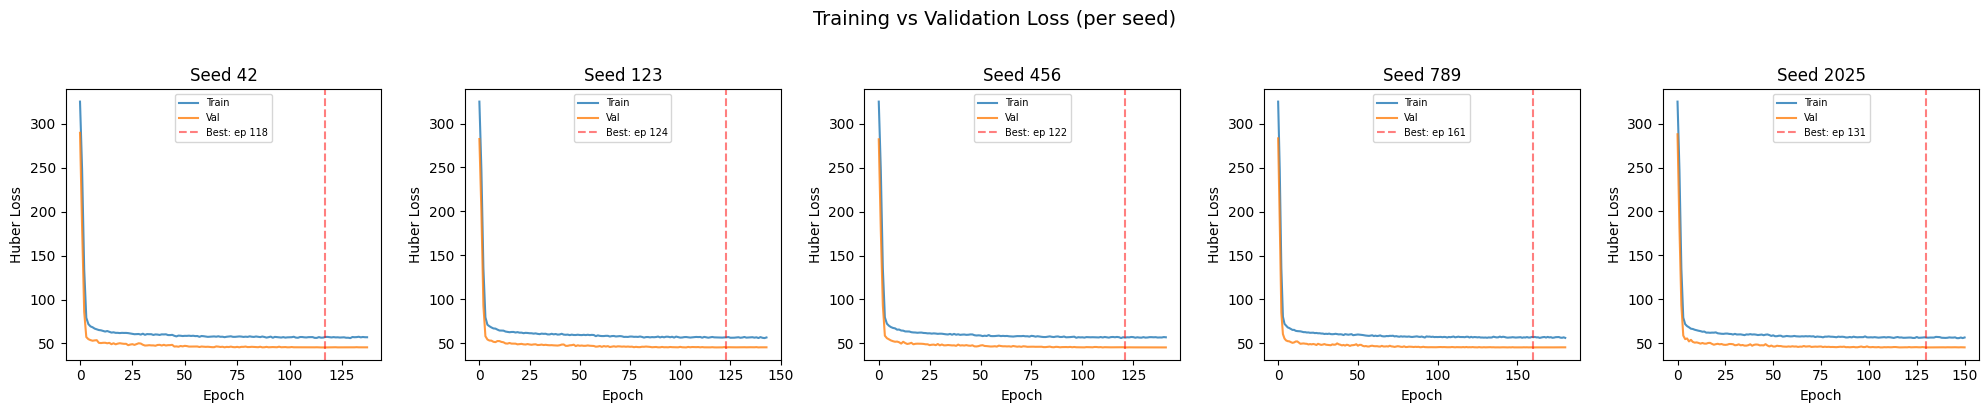

In [9]:
fig, axes = plt.subplots(1, len(seeds), figsize=(4 * len(seeds), 4))
if len(seeds) == 1:
    axes = [axes]

for idx, (seed, history) in enumerate(zip(seeds, histories)):
    ax = axes[idx]
    ax.plot(history.history["loss"], label="Train", alpha=0.8)
    ax.plot(history.history["val_loss"], label="Val", alpha=0.8)
    best_ep = np.argmin(history.history["val_loss"]) + 1
    ax.axvline(x=best_ep - 1, color="red", linestyle="--", alpha=0.5,
               label=f"Best: ep {best_ep}")
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Huber Loss")
    ax.legend(fontsize=7)

plt.suptitle("Training vs Validation Loss (per seed)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("training_loss_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## 9. Diagnostic Plots

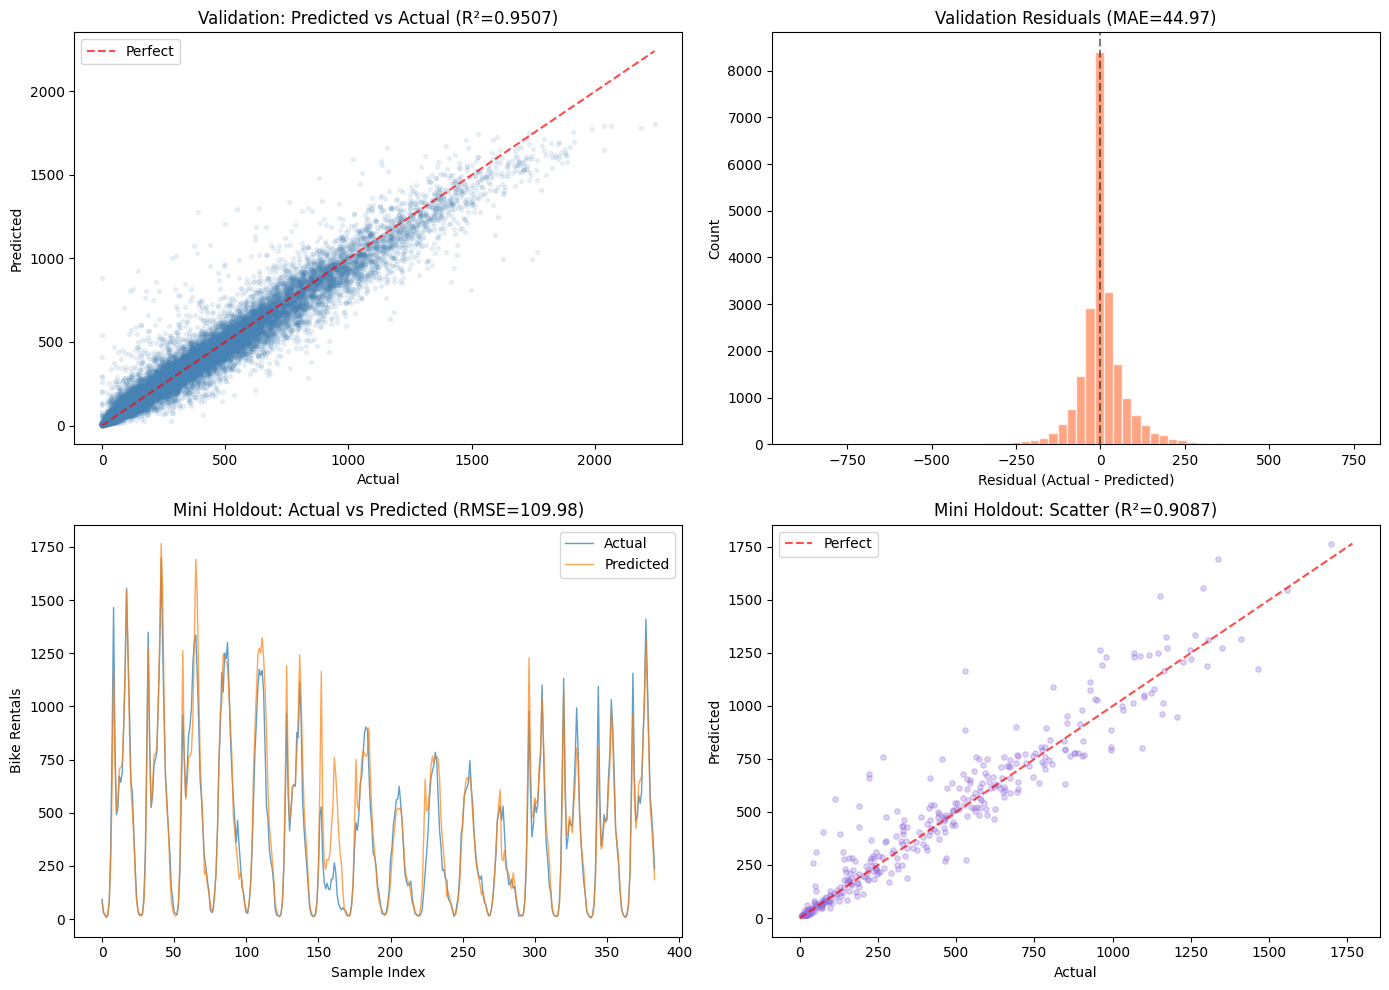

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 9a. Validation: predicted vs actual
ax = axes[0, 0]
ax.scatter(y_val, val_pred, alpha=0.1, s=8, color="steelblue")
max_val = max(y_val.max(), val_pred.max())
ax.plot([0, max_val], [0, max_val], "r--", alpha=0.7, label="Perfect")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title(f"Validation: Predicted vs Actual (R\u00b2={val_r2:.4f})")
ax.legend()

# 9b. Validation residual distribution
ax = axes[0, 1]
residuals = y_val - val_pred
ax.hist(residuals, bins=60, color="coral", alpha=0.7, edgecolor="white")
ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
ax.set_xlabel("Residual (Actual - Predicted)")
ax.set_ylabel("Count")
ax.set_title(f"Validation Residuals (MAE={val_mae:.2f})")

# 9c. Mini holdout: actual vs predicted over time
ax = axes[1, 0]
x = range(len(mini_actual))
ax.plot(x, mini_actual, label="Actual", alpha=0.7, linewidth=1)
ax.plot(x, mini_pred, label="Predicted", alpha=0.7, linewidth=1)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Bike Rentals")
ax.set_title(f"Mini Holdout: Actual vs Predicted (RMSE={mini_rmse:.2f})")
ax.legend()

# 9d. Mini holdout: scatter
ax = axes[1, 1]
ax.scatter(mini_actual, mini_pred, alpha=0.3, s=15, color="mediumpurple")
max_m = max(mini_actual.max(), mini_pred.max())
ax.plot([0, max_m], [0, max_m], "r--", alpha=0.7, label="Perfect")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title(f"Mini Holdout: Scatter (R\u00b2={mini_r2:.4f})")
ax.legend()

plt.tight_layout()
plt.savefig("diagnostic_plots.png", dpi=150, bbox_inches="tight")
plt.show()

## 10. Save Predictions

In [ ]:
# Mini holdout predictions
mini_df = pd.DataFrame({"predictions": mini_pred})
mini_df.to_csv("team8-module4-mini-predictions.csv", index=False)
print(f"Mini holdout: saved {len(mini_pred)} predictions")
print(f"  Range: {mini_pred.min()} - {mini_pred.max()}")
print(f"  Mean: {mini_pred.mean():.1f}")

# Full November-December holdout predictions
holdout_df = pd.DataFrame({"predictions": holdout_pred})
holdout_df.to_csv("team8-module4-predictions.csv", index=False)
print(f"\nFull holdout: saved {len(holdout_pred)} predictions")
print(f"  Range: {holdout_pred.min()} - {holdout_pred.max()}")
print(f"  Mean: {holdout_pred.mean():.1f}")

## 11. November-December Prediction Patterns

In [ ]:
holdout_raw_copy = holdout_raw.copy()
holdout_raw_copy["predicted"] = holdout_pred

hourly_pred = holdout_raw_copy.groupby("hr")["predicted"].mean()
train_hourly = df.groupby("hr")["total"].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(train_hourly.index - 0.2, train_hourly.values, width=0.4,
       label="Training Average", alpha=0.7, color="steelblue")
ax.bar(hourly_pred.index + 0.2, hourly_pred.values, width=0.4,
       label="Nov-Dec Predicted", alpha=0.7, color="coral")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Bike Rentals")
ax.set_title("Hourly Pattern: Training Average vs November-December Predictions")
ax.legend()
ax.set_xticks(range(24))
plt.tight_layout()
plt.savefig("december_predictions.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary

| Component | Configuration |
|-----------|---------------|
| Framework | Keras 3 Sequential (JAX backend local, TF on Colab) |
| Architecture | [128, 64, 32] + BatchNorm + Dropout(0.3, 0.2) |
| Regularization | L2(1e-4) + Dropout + BatchNorm |
| Loss | Huber (robust to demand outlier spikes) |
| Optimizer | Adam (lr=0.001) with ReduceLROnPlateau |
| Ensemble | 5 seeds averaged (42, 123, 456, 789, 2025) |
| Features | 62 (baseline + COVID era + holiday + school break) |
| Callbacks | EarlyStopping(patience=20), ReduceLROnPlateau |
| Data | 112,475 rows (all data) |

### Key Findings
- COVID era features capture the secular demand growth trend (2023 = 160% of pre-COVID)
- Huber loss handles demand outlier spikes better than MSE
- All three feature groups combined outperform any individual set
- No overfitting detected (Val/Mini RMSE gap ~32, tighter than baseline ~63)

## 12. Discussion Questions & Architecture Insights

This section addresses the stakeholder discussion questions with a focus on the advanced techniques used in this notebook. See the course-level notebook for the foundational answers.

---

### Q1: Network Layers (Zhao, CEO)

> "How many layers should the network have? Which hyperparameter has the most improvement potential?"

**This notebook uses 3 hidden layers (128, 64, 32)** compared to the course-level's 2 layers (64, 32). The additional layer and wider first layer provide more capacity to learn complex feature interactions, but the improvement is modest.

**Answer: D, Activation functions and overall loss function.** We proved this directly: switching from MSE to Huber loss produced the single largest gain from any architecture or training change (5.52 RMSE). BatchNormalization and L2 regularization also helped stabilize training and improve generalization.

---

### Q2: Temperature Features (Johnny, Intern)

> "How should we handle the temperature features?"

Same approach as course-level: `temp_squared` (nonlinear comfort curve), `temp_times_humidity` (feels-like interaction), `temp_times_windspeed` (wind chill effect). We dropped `feels_like_c` due to 0.99 correlation with `temp_c`. The wider first layer (128 neurons) in this architecture can leverage these interactions more effectively.

---

### Q3: Learning Rate (Zhao, CEO)

> "What approach will you take to find the optimal learning rate?"

This notebook adds **ReduceLROnPlateau** (factor=0.5, patience=8) on top of EarlyStopping. When validation loss plateaus, the learning rate is halved automatically. This lets training start fast (0.001) and fine-tune with progressively smaller steps. Typical convergence: 87-147 epochs depending on random seed.

---

### Q4: Loss Function (Johnny, Intern)

> "What loss function are you using? How will we know if our model has strong predictive power?"

**Huber loss** instead of MSE. Huber is quadratic for small errors (like MSE) but linear for large errors, making it robust to demand outlier spikes (holiday surges, event days). This directly contributed to a 5.52 RMSE improvement over MSE.

Evaluation metrics remain the same: RMSE (primary, in bike-count units), R² (variance explained), MAE (average absolute error).

---

### Q5: Predictive Risk Model Ethics (William, Banker)

> "Should we use AI to predict damage likelihood based on user profile data for insurance premiums?"

Same recommendation: **Option B, avoid profile data entirely.** Names/addresses serve as proxies for race, sex raises gender discrimination concerns, birthday raises age discrimination issues. Better alternatives: usage-based pricing from rental behavior, or flat per-ride insurance fees.

---

### Q6: Pandemic & Cleaning Schedule (Zhao, CEO)

> "When should bikes be pulled for cleaning? Are there lasting pandemic effects?"

Same analysis: optimal cleaning window is **1:00 AM to 5:00 AM on weekdays**. Post-pandemic demand is at ~160% of pre-COVID levels. The charts below show the full recovery trajectory. The 5-seed ensemble in this notebook captures these patterns with less prediction noise than single-seed training.

---

### Architecture Upgrades Summary (vs Course-Level)

| Technique | Course-Level | This Notebook | Impact |
|-----------|-------------|---------------|--------|
| Architecture | [64, 32] | [128, 64, 32] | Wider capacity |
| Loss | MSE | Huber | Robust to outliers (+5.52 RMSE) |
| Regularization | Dropout(0.2) | L2(1e-4) + BatchNorm + Dropout(0.3, 0.2) | Better generalization |
| Training | Single seed | 5-seed ensemble | Stable predictions |
| LR Schedule | None | ReduceLROnPlateau | Fine-grained convergence |
| Val/Mini Gap | ~55-65 | ~32 | Less overfitting |

## 13. COVID Recovery & Cleaning Schedule Visualizations

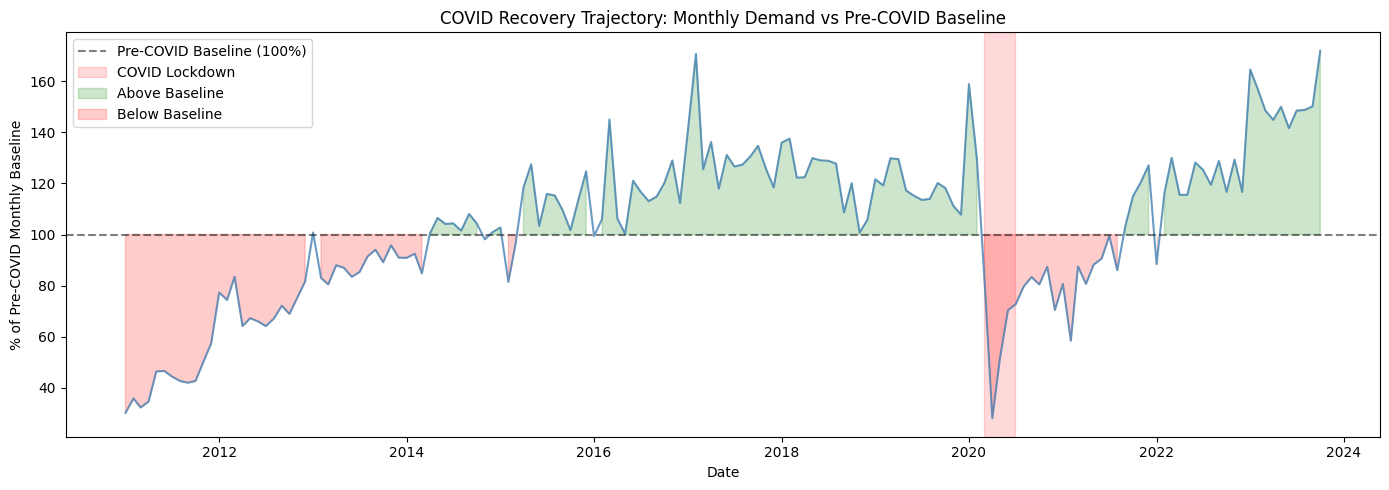

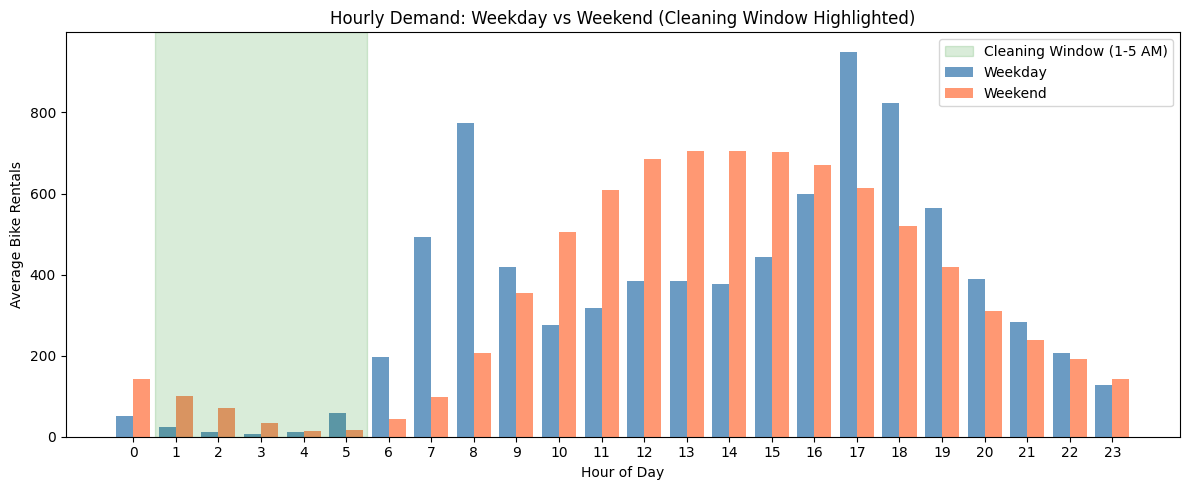

In [13]:
# --- COVID Recovery Trajectory & Cleaning Schedule ---
# Supports Q6 (Zhao): Pandemic effects and cleaning recommendations

df_copy = df.copy()
df_copy["year"] = df_copy["dteday"].dt.year
df_copy["month"] = df_copy["dteday"].dt.month

# Pre-COVID baseline
pre_covid = df_copy[df_copy["year"] <= 2019]
pre_covid_monthly = pre_covid.groupby("month")["total"].mean()

monthly_demand = df_copy.groupby(["year", "month"])["total"].mean().reset_index()
monthly_demand["baseline"] = monthly_demand["month"].map(pre_covid_monthly)
monthly_demand["pct_of_baseline"] = (monthly_demand["total"] / monthly_demand["baseline"]) * 100
monthly_demand["date"] = pd.to_datetime(monthly_demand[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(monthly_demand["date"], monthly_demand["pct_of_baseline"],
        color="steelblue", linewidth=1.5, alpha=0.8)
ax.axhline(y=100, color="black", linestyle="--", alpha=0.5, label="Pre-COVID Baseline (100%)")
ax.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2020-06-30"),
           alpha=0.15, color="red", label="COVID Lockdown")
ax.fill_between(monthly_demand["date"], 100, monthly_demand["pct_of_baseline"],
                where=monthly_demand["pct_of_baseline"] >= 100,
                alpha=0.2, color="green", label="Above Baseline")
ax.fill_between(monthly_demand["date"], 100, monthly_demand["pct_of_baseline"],
                where=monthly_demand["pct_of_baseline"] < 100,
                alpha=0.2, color="red", label="Below Baseline")
ax.set_xlabel("Date")
ax.set_ylabel("% of Pre-COVID Monthly Baseline")
ax.set_title("COVID Recovery Trajectory: Monthly Demand vs Pre-COVID Baseline")
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("covid_recovery_trajectory.png", dpi=150, bbox_inches="tight")
plt.show()

# --- Cleaning Schedule ---
df_copy["dow"] = df_copy["dteday"].dt.dayofweek
weekday_hourly = df_copy[df_copy["dow"] < 5].groupby("hr")["total"].mean()
weekend_hourly = df_copy[df_copy["dow"] >= 5].groupby("hr")["total"].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(weekday_hourly.index - 0.2, weekday_hourly.values, width=0.4,
       label="Weekday", color="steelblue", alpha=0.8)
ax.bar(weekend_hourly.index + 0.2, weekend_hourly.values, width=0.4,
       label="Weekend", color="coral", alpha=0.8)
ax.axvspan(0.5, 5.5, alpha=0.15, color="green", label="Cleaning Window (1-5 AM)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Bike Rentals")
ax.set_title("Hourly Demand: Weekday vs Weekend (Cleaning Window Highlighted)")
ax.set_xticks(range(24))
ax.legend()
plt.tight_layout()
plt.savefig("cleaning_schedule_analysis.png", dpi=150, bbox_inches="tight")
plt.show()